In [1]:
import pandas as pd 
import numpy as np
import re
import random 
# https://github.com/petrosDemetrakopoulos/RNN-Beatles-lyrics-generator
# https://github.com/starry91/Lyric-Generator#2-lyric-generator-based-on-word-level-rnn

In [2]:
import torch 
print(torch.cuda.is_available())
torch.cuda.current_device()

True


0

In [3]:
if torch.cuda.is_available():
    device = torch.device("cuda:0")  # you can continue going on here, like cuda:1 cuda:2....etc. 
    print("Running on the GPU")
else:
    device = torch.device("cpu")
    print("Running on the CPU")

Running on the GPU


In [4]:
# ssh -i "ling380.pem" ec2-user@ec2-3-21-233-161.us-east-2.compute.amazonaws.com

In [5]:
# Reading in language CSV 
data = pd.read_csv("language-processed-data.csv")
data = data.loc[:, ~data.columns.str.contains('^Unnamed')]
data["genre"].replace({"country": "Country", "soul": "Soul", "jazz":"Jazz", 
                            "folk":"Folk", "pop":"Pop", "metal":"Metal", "rb":"R&B", 
                            "rock":"Rock", "rap":"Rap"}, inplace=True)
print(data.groupby(['genre']).size())

genre
Country           20115
Electronic         7009
Folk               5777
Hip-Hop           23045
Indie              2971
Jazz              12247
Metal             29418
Not Available     17582
Other              3985
Pop               43211
R&B                7704
Rap               10105
Rock             110690
Soul               4069
dtype: int64


In [6]:
print(data.shape)
print(data.head())

(297928, 6)
            artist genre            title  \
0  beyonce-knowles   Pop        ego remix   
1  beyonce-knowles   Pop     then tell me   
2  beyonce-knowles   Pop          honesty   
3  beyonce-knowles   Pop  you are my rock   
4  beyonce-knowles   Pop    black culture   

                                              lyrics  word_num language  
0  Oh baby, how you doing?\nYou know I'm gonna cu...       NaN       en  
1  playin' everything so easy,\nit's like you see...       NaN       en  
2  If you search\nFor tenderness\nIt isn't hard t...       NaN       en  
3  Oh oh oh I, oh oh oh I\n[Verse 1:]\nIf I wrote...       NaN       en  
4  Party the people, the people the party it's po...       NaN       en  


## Prediction

- User inputs a song title, and how many words they want the song to be. 
- Network does, for example, 100 predictions, and in the training phrase we know what word we need to generate. 
- (genre, song title); have a marker that it's the end of the title 

# Word Level LSTM

In [7]:
stopChars = [',','(',')','.','-','[',']','"']
# preprocessing the corpus by converting all letters to lowercase, 
# replacing blank lines with blank string and removing special characters
def preprocessText(text):
#     text = text.replace('\n', ' ').replace('\t','')
    processedText = text.lower()
    for char in stopChars:
        processedText = processedText.replace(char,'')
    return processedText

# tokenization 
def corpusToList(corpus):
    corpusList = [w for w in corpus.split(' ')] 
    corpusList = [i for i in corpusList if i] #removing empty strings from list
    return corpusList

In [8]:
def sample_data(genre, sample_size):
    random.seed(69)
    data1 = data
    data1 = data1[data1['genre'] == genre].sample(sample_size)
    data1['lyrics'] = data1['lyrics'].astype(str)
    data1['lyrics']= data1['lyrics'].apply(preprocessText)
    return data1

In [9]:
def tokenize_data(data):
    newlines = re.sub("\n", " \n ", data['lyrics'].str.cat(sep='\n').lower())
    exclamation = re.sub("!", " ! ", newlines)
    question = re.sub("!", " ! ", exclamation)
    DP_text = re.findall(r'\S+|\n', question)
    print('corpus length:', len(DP_text))
    return(DP_text)

In [10]:
# Create a dictionary of characters, see the index of characters.
def dictionary_maker(words):
    char_to_int = dict((c, i) for i, c in enumerate(words))
    int_to_char = dict((i, c) for i, c in enumerate(words))
    return(char_to_int, int_to_char)

In [11]:
def make_sentences_and_next_chars(seq_length, DP_text, step):
    sentences = []
    next_chars = []

    # Create Target and sentences window
    for i in range(0, len(DP_text) - seq_length, step):
        # range from current index to sequence length charaters
        sentences.append(DP_text[i: i + seq_length])  
        next_chars.append(DP_text[i + seq_length]) # the next character
    
    sentences = np.array(sentences)
    next_chars = np.array(next_chars)
    return(sentences, next_chars)

In [12]:
rap_data = sample_data('Rock', 6000)
print(rap_data.shape)
print(rap_data.genre.unique())
#pop_data = sample_data('pop', 2000)
#country_data = sample_data('country', 2000)

(6000, 6)
['Rock']


In [13]:
DP_rap = tokenize_data(rap_data)
#DP_pop = tokenize_data(pop_data)
#DP_country = tokenize_data(country_data)

corpus length: 1369100


In [14]:
# Counting characters appeared in all lyrics
rap_words = sorted(list(set(DP_rap)))
#pop_words = sorted(list(set(DP_pop)))
#country_words = sorted(list(set(DP_country)))

In [15]:
rap_char_to_int, rap_int_to_char = dictionary_maker(rap_words)
#pop_char_to_int, pop_int_to_char = dictionary_maker(pop_words)
#country_char_to_int, country_int_to_char = dictionary_maker(country_words)

In [16]:
rap_sentences, rap_next_chars = make_sentences_and_next_chars(16, DP_rap, 1)
#pop_sentences, pop_next_chars = make_sentences_and_next_chars(16, DP_pop, 1)
#country_sentences, country_next_chars = make_sentences_and_next_chars(16, DP_country, 1)

In [17]:
# transferring the character to index 
def getdata(sentences, next_chars, seq_length, char_to_int):
    X = np.zeros((len(sentences),seq_length))
    y = np.zeros((len(sentences)))
    length = len(sentences)
    index = 0
    for i in range(len(sentences)):
        sentence = sentences[i]
        for t, char in enumerate(sentence):
            X[i, t] = char_to_int[char]
        y[i] = char_to_int[next_chars[i]]
    return X, y

In [18]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable

In [19]:
class Simple_LSTM(nn.Module):
    def __init__(self,n_vocab,hidden_dim, embedding_dim,dropout = 0.2):
        super(Simple_LSTM, self).__init__()
        
        self.hidden_dim = hidden_dim
        self.embedding_dim = embedding_dim
        self.lstm = nn.LSTM(embedding_dim, hidden_dim,dropout = dropout,num_layers = 2)
        self.embeddings = nn.Embedding(n_vocab, embedding_dim)
        self.fc = nn.Linear(hidden_dim, n_vocab)
    
    def forward(self, seq_in):
        # for LSTM, input should be (Sequnce_length,batchsize,hidden_layer), so we need to transpose the input
        embedded = self.embeddings(seq_in.t()) 
        lstm_out, _ = self.lstm(embedded)
        # Only need to keep the last character 
        ht=lstm_out[-1] 
        out = self.fc(ht)
        return out

In [20]:
def train_model(sentences, next_chars, epoch_count, words, seq_length, char_to_int):
    train_x, train_y = getdata(sentences, next_chars, seq_length, char_to_int)
    
    X_train_tensor = torch.tensor(train_x, dtype=torch.long).to(device)
    Y_train_tensor = torch.tensor(train_y, dtype=torch.long).to(device)
    
    from torch.utils.data import Dataset, DataLoader
    train = torch.utils.data.TensorDataset(X_train_tensor,Y_train_tensor)
    train_loader = torch.utils.data.DataLoader(train, batch_size = 128)
    
    model = Simple_LSTM(len(words),256,256).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr = 0.002)
    
    import time # Add time counter
    avg_losses_f = []
    n_epochs = epoch_count

    for epoch in range(n_epochs):
        print("Epoch: ", epoch)
        start_time = time.time()
        model.train()
        loss_fn = torch.nn.CrossEntropyLoss()
        avg_loss = 0.
        for i, (x_batch, y_batch) in enumerate(train_loader):
        
            y_pred = model(x_batch)
        
            loss = loss_fn(y_pred, y_batch)
            optimizer.zero_grad()
            loss.backward()
        
            optimizer.step()
            avg_loss+= loss.item()/len(train_loader)
        
        elapsed_time = time.time() - start_time 
        print('Epoch {}/{} \t loss={:.4f} \t time={:.2f}s'.format(
            epoch + 1, n_epochs, avg_loss, elapsed_time))
    
        avg_losses_f.append(avg_loss)    
    
    print('All \t loss={:.4f} \t '.format(np.average(avg_losses_f)))
    
    import matplotlib.pyplot as plt

    plt.plot(avg_losses_f)
    plt.xlabel('Epoch')
    plt.ylabel('Loss value')
    plt.show()
    
    
    return(model)

Epoch:  0
Epoch 1/20 	 loss=5.4158 	 time=961.45s
Epoch:  1
Epoch 2/20 	 loss=4.8779 	 time=963.82s
Epoch:  2
Epoch 3/20 	 loss=4.6611 	 time=964.63s
Epoch:  3
Epoch 4/20 	 loss=4.4873 	 time=964.69s
Epoch:  4
Epoch 5/20 	 loss=4.3554 	 time=963.84s
Epoch:  5
Epoch 6/20 	 loss=4.2534 	 time=964.34s
Epoch:  6
Epoch 7/20 	 loss=4.1654 	 time=963.92s
Epoch:  7
Epoch 8/20 	 loss=4.0934 	 time=963.88s
Epoch:  8
Epoch 9/20 	 loss=4.0312 	 time=963.72s
Epoch:  9
Epoch 10/20 	 loss=3.9826 	 time=963.65s
Epoch:  10
Epoch 11/20 	 loss=3.9408 	 time=964.17s
Epoch:  11
Epoch 12/20 	 loss=3.9029 	 time=963.84s
Epoch:  12
Epoch 13/20 	 loss=3.8714 	 time=963.46s
Epoch:  13
Epoch 14/20 	 loss=3.8435 	 time=963.67s
Epoch:  14
Epoch 15/20 	 loss=3.8166 	 time=963.53s
Epoch:  15
Epoch 16/20 	 loss=3.7968 	 time=963.00s
Epoch:  16
Epoch 17/20 	 loss=3.7764 	 time=962.47s
Epoch:  17
Epoch 18/20 	 loss=3.7580 	 time=694.05s
Epoch:  18
Epoch 19/20 	 loss=3.7399 	 time=547.05s
Epoch:  19
Epoch 20/20 	 loss=3

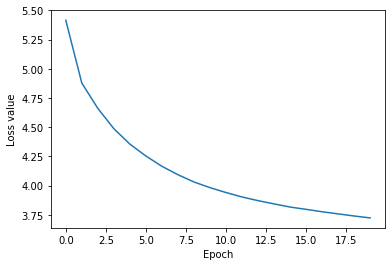

rock done


In [21]:
rock_model = train_model(rap_sentences, rap_next_chars, 20, rap_words, 16, rap_char_to_int)
torch.save(rock_model.state_dict(), 'rock_checkpoint.pth')
print("rock done")

In [22]:
#pop_model = train_model(pop_sentences, pop_next_chars, 5, pop_words, 16, pop_char_to_int)
# print("pop done")

In [23]:
#country_model = train_model(country_sentences, country_next_chars, 5, country_words, 16, country_char_to_int)
# print("country done")

In [24]:
def sample(preds, temperature=1.0):
    preds = np.asarray(preds).astype('float64')
    preds = np.log(preds) / temperature
    exp_preds = np.exp(preds)
    preds = exp_preds / np.sum(exp_preds)
    probas = np.random.multinomial(1, preds, 1)
    return np.argmax(probas)

In [25]:
# Define the start sentence
# sentence = 'i read in the news\nthat the average man\nplease kis'
seq_length = 16
char_to_int = rap_char_to_int
int_to_char = rap_int_to_char
sentence = ["on", "god", "i", "love", "the", "blow", "\n", "on", "god", "i",
           "love", "the", "pussy", "\n", "but", "more"]
variance = .5
generated = []
original = sentence
window = sentence

for i in range(400):
    x = np.zeros((1, seq_length))
    for t, char in enumerate(window):
        x[0, t] = char_to_int[char] # Change the sentence to index vector shape (1,50)
        
    x_in = Variable(torch.LongTensor(x).to(device))
    pred = rock_model(x_in)
    pred = np.array(F.softmax(pred, dim=1).data[0].cpu())
    next_index = sample(pred, variance)
    next_char = int_to_char[next_index] # index to char

    generated = generated + [next_char]
    window = window[1:] + [next_char] # Update Window for next char predict
    
print(" ".join(original + generated))

on god i love the blow 
 on god i love the pussy 
 but more than slave 
 rots and moan 
 and i'm on my shoulders 
 rushin' around my head 
 my home's will restore 
 and i've gotten away 
 and i know what i mean 
 and i want to find you 
 i know you know 
 i'm not gonna start this thing 
 and lend me a smile 
 and i don't know what it means 
 how can i have to be a father 
 i'm a rebel rebel 
 am i a preacher's son 
 who knows i'm a liar 
 i got the sugar 
 i love you 
 but i want to be 
 cause i don't know what i want 
 i wish i could be here 
 i'm not sure i'm losing control 
 i know i miss you for 
 you've got to hide 
 i wish i could fly 
 to be the only one 
 to see me again 
 i wish that i could be in love 
 and i know i know that you are 
 i couldn't see you 
 i was my love 
 you'll be your worrying 
 i could just be found 
 i want you to be for you 
 i don't know you 
 i don't wanna be back 
 i don't wanna wait 
 i'm not listening 
 i don't know what to do 
 i got a date i’ll 
 

# Analysis

In [26]:
starters = [["i", "like", "long", "walk", "on", "the", "beach", "\n", "and", "shopping", "runs", "in", "paris", "\n", "i", "sometimes"],
["it", "was", "a", "dark", "day", "when", "he", "died", "\n", "my", "mom",  "had", "tears", "in", "her", "eyes"],
["yeah", "\n", "yeah", "\n", "yeah", "\n", "this", "is", "the", "way", "i", "talk", "when", "i’m", "mad", "\n"],
["drive", "forever", "\n", "baby", "i", "need", "your", "heart", "\n", "free", "car", "\n", "just", "another", "a", "wild"],
["the", "way", "that", "you", "love", "me", "\n", "is", "hard", "to", "explain", "\n", "i’m", "addicted", "to", "your"],
["love", "women", "\n", "get", "money", "\n", "love", "women", "\n", "get", "money", "\n", "makes", "a", "lot", "of"],
["baby", "you", "are", "crazy", "\n", "you", "make", "no", "sense", "\n", "talking", "to", "you", "\n", "is", "like"],
["it’s", "been", "a", "while", "since", "you", "spoke", "to", "me", "\n", "turned", "your", "head", "\n", "cracked", "a"],
["lies", "spreading", "round", "\n", "that", "you've", "been", "seen", "with", "him", "\n", "guess", "i", "wasn’t", "enough", "for"],
["i", "been", "all", "over", "this", "god", "damn", "town", "\n", "under", "the", "bridges", "and", "up", "in", "the"],
["oh", "oh", "oh", "\n", "yeah", "yeah", "yeah", "\n", "that’s", "what", "i’m", "talkin", "about", "\n", "look", "at"],
["well", "i", "was", "walking", "round", "town", "with", "this", "girl", "i", "knew", "\n", "when", "a", "man", "came"],
["fire", "and", "flames", "\n", "passing", "tongues", "once", "bright", "with", "life", "\n", "this", "is", "the", "world", "as"],
["on", "god", "i", "love", "the", "women", "\n", "on", "god", "i", "love", "the", "blow", "\n", "on", "god"],
["i", "can", "take", "you", "to", "the", "west", "coast", "best", "coast", "with", "a", "piece", "of", "toast", "yeah"],
["the", "stars", "were", "golden", "\n", "the", "sky", "was", "dark", "\n", "it", "was", "just", "you", "and", "me"],
["please", "baby", "please", "\n", "please", "baby", "please", "\n", "the", "things", "you", "do", "to", "me", "\n", "you"],
["sweet", "adam", "\n", "your", "tender", "touch", "\n", "all", "i", "need", "when", "the", "weather", "gets", "cold", "\n"],
["hello", "there", "\n", "the", "toy", "from", "my", "nightmare", "\n", "the", "figure", "in", "front", "of", "me", "\n"],
["i", "like", "to", "spit", "\n", "in", "the", "morning", "when", "i’m", "done", "taking", "my", "shit", "\n", "i"]]

seq_length = 16
char_to_int = rap_char_to_int
int_to_char = rap_int_to_char

def generate_sentence(input_sentences): 
    starter = [] 
    generation = [] 
    
    for i in range(len(input_sentences)): 
        print("In sentence: ", i)
        variance = .5
        generated = []
        original = input_sentences[i]
        window = input_sentences[i]

        for i in range(400):
            x = np.zeros((1, seq_length))
            for t, char in enumerate(window):
                x[0, t] = char_to_int[char] # Change the sentence to index vector shape (1,50)

            x_in = Variable(torch.LongTensor(x).to(device))
            pred = rock_model(x_in)
            pred = np.array(F.softmax(pred, dim=1).data[0].cpu())
            next_index = sample(pred, variance)
            next_char = int_to_char[next_index] # index to char

            generated = generated + [next_char]
            window = window[1:] + [next_char] # Update Window for next char predict
        
        starter.append(original) 
        generation.append(generated)

    lyrics = pd.DataFrame({'starter': starter, 'output': generation})
    print(lyrics.head())
    return lyrics 
output = generate_sentence(starters)

In sentence:  0
In sentence:  1


/home/ubuntu/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/ipykernel/__main__.py:3: RuntimeWarning: divide by zero encountered in log
  app.launch_new_instance()


In sentence:  2
In sentence:  3
In sentence:  4
In sentence:  5
In sentence:  6
In sentence:  7
In sentence:  8


KeyError: 'wasn’t'

In [ ]:
# METRIC 1: AVERAGE LINE LENGTH 
import math
def mean(numbers):
    return float(sum(numbers)) / max(len(numbers), 1)
def single_length_length(output): 
    newline_count = output.count('\n')
    return round((len(output) - newline_count) / (newline_count + 1), 2)
def average_line_length(df): 
    # (length of the list - # of new lines) / (# new lines + 1 )
    result = df['output'].apply(single_length_length).tolist()
    return mean(result)

# METRIC 2: Word variation: # of Unique words divided by total # of words 
def variation(output): 
    line = [value for value in output if value != "\n"]
    unique_num = len(list(set(line)))
    return unique_num/len(line)
def word_variation(df): 
    result = df['output'].apply(variation).tolist()
    return mean(result)

# METRIC 3: Genre Word Variation 
def genre_word_variation(df): 
    output_list = df['output'].tolist()
    return variation(output_list[0])

# METRIC 4: % of I vs. You 
def count_iyou(row): 
    i_count, you_count = 0,0 
    x = 0
    while x < len(row):
        if x == 0 and row[x] == "you": 
            you_count += 1
        if x == 0 and row[x] == "i":
            i_count += 1 
        if x < len(row) - 1: 
            if row[x] == "\n" and row[x + 1] == "i": 
                i_count += 1 
            if row[x] == "\n" and row[x + 1] == "you": 
                you_count += 1
        x += 1 

    return (i_count - you_count)

def i_you(df): 
    result = df['output'].apply(count_iyou).to_list()
    return mean(result)
# the more positive, the more i's there are. 

# METRIC 5: Word reptition 
# if the word is the same as the one that came before it 
def count_s(row): 
    count, x = 0, 0
    while x < len(row): 
        if x < len(row) - 1: 
            if row[x] == row[x+1]: 
                count += 1 
        x += 1 
    return count 
def count_succession(df): 
    result = df['output'].apply(count_s).to_list()
    return mean(result)

# METRIC 1: AVERAGE LINE LENGTH 
print(average_line_length(output))
# METRIC 2: Word variation: # of Unique words divided by total # of words 
print(word_variation(output))
# METRIC 3: Genre Word Variation 
print(genre_word_variation(output))
# METRIC 4: % of I vs. You 
print(i_you(output))
# METRIC 5: Word repetition 
print(count_succession(output)) 

In [ ]:
# For the Original Data

In [ ]:
def sample_data(genre, sample_size):
    random.seed(69)
    data1 = data
    data1 = data1[data1['genre'] == genre].sample(sample_size)
    data1['lyrics'] = data1['lyrics'].astype(str)
    data1['lyrics']= data1['lyrics'].apply(preprocessText)
    return data1

def tokenize_data(data):
    newlines = re.sub("\n", " \n ", data.lower())
    exclamation = re.sub("!", " ! ", newlines)
    question = re.sub("!", " ! ", exclamation)
    DP_text = re.findall(r'\S+|\n', question)
    return(DP_text)

r_data = sample_data('Rock', 2000)
r_data['output'] = r_data['lyrics'].apply(tokenize_data)

# METRIC 1: AVERAGE LINE LENGTH 
print(average_line_length(r_data))
# METRIC 2: Word variation: # of Unique words divided by total # of words 
print(word_variation(r_data))
# METRIC 3: Genre Word Variation 
print(genre_word_variation(r_data))
# METRIC 4: % of I vs. You 
print(i_you(r_data))
# METRIC 5: Word repetition 
print(count_succession(r_data)) 